<a href="https://colab.research.google.com/github/AVL1/TextGeneration/blob/main/text_generation_ngram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h2>Text generation</h2></center>

###IMPORTS

In [ ]:
from google.colab import drive
import pandas as pd
import re
import string
import random

###1. Mount drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


---
###2. Read data

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Datasets/headlines.csv', header=None)[0]
dataset = dataset.to_list()

In [ ]:
dataset[:10]

['headline',
 'Former N.F.L. Cheerleadersâ€™ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'How a Bag of Texas Dirt  Became a Times Tradition']

---
###3. Pre-processing

In [ ]:
def split_to_sentences(dts):
  """
  Split each line of dataset to sentences if possible.
  Input (parameter dts) should be either:
    1. List: each element is a string.
    2. String.
  Return: dataset[]
          Each element in dataset[] is a string.
  """
  new_dts = []
  for i in range(len(dts)):
    tmp = re.split(r'[.?!]\s*', dts[i])
    for sent in tmp:
      if sent:
        new_dts.append(sent)
  return new_dts

In [ ]:
dataset = split_to_sentences(dataset)

####4.1 Remove HTML tags

In [ ]:
def remove_html(dts):
  """
  Remove HTML tags from dataset.
  Eg: <br>, <h1>,...
  Return: dataset[]
  """
  cleanr = re.compile('<.*?>')
  for i in range(len(dts)):
    dts[i] = re.sub(cleanr, '', dts[i])
  return dts

In [ ]:
dataset = remove_html(dataset)

In [ ]:
dataset[:10]

['headline',
 'Former N',
 'F',
 'L',
 'Cheerleadersâ€™ Settlement Offer: $1 and a Meeting With Goodell',
 'E',
 'P',
 'A',
 'to Unveil a New Rule',
 'Its Effect: Less Science in Policymaking']

####4.2 Lowercase

In [ ]:
def lowercase(dts):
  """
  Convert each sentence in dataset into lowercase form.
  Return: dataset[]
  """
  for i in range(len(dts)):
    dts[i] = dts[i].lower()
  return dts

In [ ]:
dataset = lowercase(dataset)

In [ ]:
dataset[:10]

['headline',
 'former n',
 'f',
 'l',
 'cheerleadersâ€™ settlement offer: $1 and a meeting with goodell',
 'e',
 'p',
 'a',
 'to unveil a new rule',
 'its effect: less science in policymaking']

####4.3 Remove punctuations

In [ ]:
def remove_punctuations(dts):
  """
  Remove punctuations from dataset.
  Return: dataset[]
  """
  for i in range(len(dts)):
    for punc in string.punctuation:
      dts[i] = dts[i].replace(punc, '')
  return dts

In [ ]:
dataset = remove_punctuations(dataset)

In [ ]:
dataset[:10]

['headline',
 'former n',
 'f',
 'l',
 'cheerleadersâ€™ settlement offer 1 and a meeting with goodell',
 'e',
 'p',
 'a',
 'to unveil a new rule',
 'its effect less science in policymaking']

####4.4 Remove special characters, retain only letters and digits

In [ ]:
def remove_special_characters(dts):
  """
  Remove special characters from dataset.
  Eg: @ # $ % ^ blank...
  Return: dataset[]
  """
  for i in range(len(dts)):
   dts[i] = re.sub('[^A-Za-z0-9 ]+', '', dts[i])
   dts[i] = ' '.join(dts[i].split())
  return dts

In [ ]:
dataset = remove_special_characters(dataset)

In [ ]:
dataset[:10]

['headline',
 'former n',
 'f',
 'l',
 'cheerleaders settlement offer 1 and a meeting with goodell',
 'e',
 'p',
 'a',
 'to unveil a new rule',
 'its effect less science in policymaking']

####4.5 Drop-out very short sentences

In [ ]:
def drop_short_sentences(dts):
  """
  Remove sentences that only have 1 or 2 word(s),
  Return: dataset[]
  """
  new_dts = []
  for sent in dts:
    if len(sent.split(' ')) > 1:
      new_dts.append(sent)
  return new_dts

In [ ]:
dataset = drop_short_sentences(dataset)

####4.6 Padding
*Add start/end of sentence symbols*

In [ ]:
def padding(dts, ngrams=2):
  """
  Add <s> and </s> to each sentence.
  Return: dataset[]
  """
  for i in range(len(dts)):
    dts[i] = '<s> '*ngrams  + dts[i] + ' </s>'*ngrams
  return dts

In [ ]:
dataset = padding(dataset)

In [ ]:
dataset[:10]

['<s> <s> former n </s> </s>',
 '<s> <s> cheerleaders settlement offer 1 and a meeting with goodell </s> </s>',
 '<s> <s> to unveil a new rule </s> </s>',
 '<s> <s> its effect less science in policymaking </s> </s>',
 '<s> <s> the new noma </s> </s>',
 '<s> <s> how a bag of texas dirt became a times tradition </s> </s>',
 '<s> <s> is school a place for selfexpression </s> </s>',
 '<s> <s> commuter reprogramming </s> </s>',
 '<s> <s> ford changed leaders </s> </s>',
 '<s> <s> romney failed to win at utah convention </s> </s>']

####4.7 Pack pre-processing methods

In [ ]:
def preprocess(dts):
  dts = remove_html(dts)
  dts = lowercase(dts)
  dts = remove_punctuations(dts)
  dts = remove_special_characters(dts)
  dts = padding(dts)
  return dts

---
###5. Train/Test split


In [ ]:
# Train/Test = 9/1
random.shuffle(dataset)
split_point = int(len(dataset) * 0.9)
training_set = dataset[:split_point]
test_set = dataset[split_point:]


---
###6. Build vocabulary

In [ ]:
def build_vocabulary(dts):
  """
  Build vocabulary from input dataset.
  Return: vocabulary[]
  """
  vocab = set()
  for sent in dts:
    for word in sent.split(' '):
      if word:
        vocab.add(word)
  return list(vocab)

In [ ]:
vocabulary = build_vocabulary(training_set)

In [ ]:
V = len(vocabulary)
print(V)

7386


In [ ]:
vocabulary[:10]

['matters',
 'meatloaf',
 'complicated',
 'ivory',
 'riders',
 'mudslides',
 'prescription',
 'pouring',
 'g',
 'runaway']

---
###6. Build **trigram** model

In [ ]:
def count_sequence(seq, dts):
  """
  Count occurrences of input sequence in entire dataset.
  Return: int
  """
  n = 0
  for sent in dts:
    n += sent.count(seq)
  return n

In [ ]:
def build_trigram_model(dts):
  """
  Build trigram model from dataset.
  The model is a dictionary with each item is (trigram sequence): probability.
  Return: model{}
  """
  model = {}
  for sent in dts:
    tokens = sent.split(' ')
    for i in range(2, len(tokens)):
      wn = tokens[i]
      wn_1 = tokens[i-1]
      wn_2 = tokens[i-2]
      
      # calculate probability with Laplace smoothing
      C_tri = count_sequence(wn_2 + ' ' + wn_1 + ' ' + wn, dts)
      C_bi = count_sequence(wn_2 + ' ' + wn_1, dts)
      prob = (C_tri + 1) / (C_bi + V)

      # save result to model
      model[(wn_2, wn_1, wn)] = prob
  
  return model

In [ ]:
trigram_model = build_trigram_model(training_set)

###7. Predict next word

In [ ]:
def generate1(seed_text, model):
  """
  Generate 1 next word that has highest probability on seed_text with probability value.
  Return: (string, float)
  """
  text = preprocess([seed_text])[0]
  text = text.split(' ')
  wn_1 = text[-3]
  wn_2 = text[-4]
  
  predicted_word = 'UNK'
  predicted_prob = 0

  for key, value in model.items():
    if wn_2 == key[0] and wn_1 == key[1]:
      if predicted_prob < value:
        predicted_word = key[2]
        predicted_prob = value
  return (predicted_word, predicted_prob)

In [ ]:
def generate(seed_text, model, n=1):
  """
  Generate n next words and probability of whole generated sequence
  until meet <UNK> or </s> symbol.
  Return: (string, float)
  """
  tmp = ''
  tmp2 = seed_text
  sent_prob = 1
  for i in range(n):
    text, prob = generate1(tmp2 + tmp, model)
    if text == 'UNK' or text == '</s>':
      break 
    tmp = tmp + ' ' + text
    sent_prob *= prob 
  return seed_text + tmp, sent_prob

In [ ]:
print(generate1('sky', trigram_model))

('UNK', 0)


In [ ]:
print(generate('what', trigram_model, 5))

('what do you think the role', 9.932321680987543e-17)


### 8. Evaluation: Perplexity

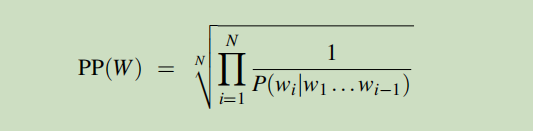

In [ ]:
test_set[:10]

['<s> <s> wishful thinkers </s> </s>',
 '<s> <s> top court rules brazil can jail former leader </s> </s>',
 '<s> <s> do you watch hollywood awards ceremonies </s> </s>',
 '<s> <s> recovery plan </s> </s>',
 '<s> <s> lastsecond nature </s> </s>',
 '<s> <s> old house </s> </s>',
 '<s> <s> what would you like to learn to make by hand </s> </s>',
 '<s> <s> trump signals readiness for battle over trade </s> </s>',
 '<s> <s> teaching orwell and 1984 with the new york times </s> </s>',
 '<s> <s> why your hip may really be killing you </s> </s>']

In [ ]:
test_vocab = build_vocabulary(test_set)

In [ ]:
def evaluate(test_set, model):
  """
  Calculate the Perplexity of N-gram language model.
  Return: float
  """
  N = 0
  for sent in test_set:
    N += len(sent.split(' '))

  PP = 1
  for sent in test_set:
    tokens = sent.split(' ')
    for i in range(2, len(tokens)):
      wn = tokens[i]
      wn_1 = tokens[i-1]
      wn_2 = tokens[i-2]

      # Find in model
      found = False
      for key, value in model.items():
        if (wn_2, wn_1, wn) == key:
          p = value**(-1/N)
          found = True
          break
      
      # If not in model:
      if found == False:
        p = (1 / V)**(-1/N)

      PP *= p

  return PP

In [ ]:
print(evaluate(test_set, trigram_model))

1226.2934428673311


---
---
##Train on Moby Dick novel 
*From [Gutenberg](https://www.gutenberg.org/)*

In [ ]:
with open('mobydick.txt', 'r', encoding='utf-8') as f:
  dataset_md = f.read()
f.close()

In [ ]:
import nltk
nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
dataset_md = dataset_md.replace('\n', ' ')
dataset_md = tokenizer.tokenize(dataset_md)

In [ ]:
dataset_md[:10]

['\ufeffCHAPTER 1.',
 'Loomings.',
 'Call me Ishmael.',
 'Some years ago—never mind how long precisely—having little or no money in my purse, and nothing particular to interest me on shore, I thought I would sail about a little and see the watery part of the world.',
 'It is a way I have of driving off the spleen and regulating the circulation.',
 'Whenever I find myself growing grim about the mouth; whenever it is a damp, drizzly November in my soul; whenever I find myself involuntarily pausing before coffin warehouses, and bringing up the rear of every funeral I meet; and especially whenever my hypos get such an upper hand of me, that it requires a strong moral principle to prevent me from deliberately stepping into the street, and methodically knocking people’s hats off—then, I account it high time to get to sea as soon as I can.',
 'This is my substitute for pistol and ball.',
 'With a philosophical flourish Cato throws himself upon his sword; I quietly take to the ship.',
 'There 

In [ ]:
dataset_md = preprocess(dataset_md)
print(len(dataset_md))

8606


In [ ]:
dataset_md[:10]

['<s> <s> chapter 1 </s> </s>',
 '<s> <s> loomings </s> </s>',
 '<s> <s> call me ishmael </s> </s>',
 '<s> <s> some years agonever mind how long preciselyhaving little or no money in my purse and nothing particular to interest me on shore i thought i would sail about a little and see the watery part of the world </s> </s>',
 '<s> <s> it is a way i have of driving off the spleen and regulating the circulation </s> </s>',
 '<s> <s> whenever i find myself growing grim about the mouth whenever it is a damp drizzly november in my soul whenever i find myself involuntarily pausing before coffin warehouses and bringing up the rear of every funeral i meet and especially whenever my hypos get such an upper hand of me that it requires a strong moral principle to prevent me from deliberately stepping into the street and methodically knocking peoples hats offthen i account it high time to get to sea as soon as i can </s> </s>',
 '<s> <s> this is my substitute for pistol and ball </s> </s>',
 '<s> <

In [ ]:
# Train/Test = 9/1
random.shuffle(dataset_md)
split_point = int(len(dataset_md) * 0.9)
training_set_md = dataset_md[:split_point]
test_set_md = dataset_md[split_point:]

In [ ]:
vocab_md = build_vocabulary(training_set_md)
V_md = len(vocab_md)
model_md = build_trigram_model(training_set_md)

In [ ]:
print(generate('i love', model_md, 10))

('i love to sail with such a whale', 7.766069161662909e-21)


In [ ]:
# Save model
with open('model-md.txt', 'w') as f:
  for key, value in model_md.items():
    f.write("{}: {}\n".format(str(key), str(value)))

In [ ]:
V = V_md
print(evaluate(test_set_md, model_md))

5234.8627281729305
